![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

# 3. Training and Reusing Named Entity Recognition Models

## Related blogposts and videos:

https://towardsdatascience.com/named-entity-recognition-ner-with-bert-in-spark-nlp-874df20d1d77

NerDL worksghop (90 min): https://www.youtube.com/watch?v=YM-e4eOiQ34

https://medium.com/spark-nlp/named-entity-recognition-for-healthcare-with-sparknlp-nerdl-and-nercrf-a7751b6ad571

https://medium.com/atlas-research/ner-for-clinical-text-7c73caddd180

In [0]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *

print("Spark NLP version", sparknlp.version())
print("Apache Spark version:", spark.version)

spark

Spark NLP version 4.3.0
Apache Spark version: 3.3.0


SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.3.0 
 Master 
 local[*] 
 AppName 
 Databricks Shell

### CoNLL Data Prep

In [0]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/src/test/resources/conll2003/eng.train
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/src/test/resources/conll2003/eng.testa

In [0]:
with open("eng.train") as f:
    train_txt =f.read()

print (train_txt[:500])

-DOCSTART- -X- -X- O

EU NNP B-NP B-ORG
rejects VBZ B-VP O
German JJ B-NP B-MISC
call NN I-NP O
to TO B-VP O
boycott VB I-VP O
British JJ B-NP B-MISC
lamb NN I-NP O
. . O O

Peter NNP B-NP B-PER
Blackburn NNP I-NP I-PER

BRUSSELS NNP B-NP B-LOC
1996-08-22 CD I-NP O

The DT B-NP O
European NNP I-NP B-ORG
Commission NNP I-NP I-ORG
said VBD B-VP O
on IN B-PP O
Thursday NNP B-NP O
it PRP B-NP O
disagreed VBD B-VP O
with IN B-PP O
German JJ B-NP B-MISC
advice NN I-NP O
to TO B-PP O
consumers NNS B-NP


In [0]:
from sparknlp.training import CoNLL

training_data = CoNLL().readDataset(spark, 'file:/databricks/driver/eng.train')

training_data.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|                 pos|               label|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|EU rejects German...|[{document, 0, 47...|[{document, 0, 47...|[{token, 0, 1, EU...|[{pos, 0, 1, NNP,...|[{named_entity, 0...|
|     Peter Blackburn|[{document, 0, 14...|[{document, 0, 14...|[{token, 0, 4, Pe...|[{pos, 0, 4, NNP,...|[{named_entity, 0...|
| BRUSSELS 1996-08-22|[{document, 0, 18...|[{document, 0, 18...|[{token, 0, 7, BR...|[{pos, 0, 7, NNP,...|[{named_entity, 0...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows



In [0]:
training_data.printSchema()

root
 |-- text: string (nullable = true)
 |-- document: array (nullable = false)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: string (valueContainsNull = true)
 |    |    |-- embeddings: array (nullable = true)
 |    |    |    |-- element: float (containsNull = false)
 |-- sentence: array (nullable = false)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: string (valueContainsNull = tr

In [0]:
%time training_data.count()

CPU times: user 1.82 ms, sys: 904 µs, total: 2.72 ms
Wall time: 1.5 s
Out[6]: 14041

In [0]:
import pyspark.sql.functions as F

training_data.select(F.explode(F.arrays_zip(training_data.token.result, 
                                            training_data.pos.result, 
                                            training_data.label.result)).alias("cols")) \
             .select(F.expr("cols['0']").alias("token"),
                     F.expr("cols['1']").alias("pos"),
                     F.expr("cols['2']").alias("ner_label")).show(truncate=50)

+----------+---+---------+
|     token|pos|ner_label|
+----------+---+---------+
|        EU|NNP|    B-ORG|
|   rejects|VBZ|        O|
|    German| JJ|   B-MISC|
|      call| NN|        O|
|        to| TO|        O|
|   boycott| VB|        O|
|   British| JJ|   B-MISC|
|      lamb| NN|        O|
|         .|  .|        O|
|     Peter|NNP|    B-PER|
| Blackburn|NNP|    I-PER|
|  BRUSSELS|NNP|    B-LOC|
|1996-08-22| CD|        O|
|       The| DT|        O|
|  European|NNP|    B-ORG|
|Commission|NNP|    I-ORG|
|      said|VBD|        O|
|        on| IN|        O|
|  Thursday|NNP|        O|
|        it|PRP|        O|
+----------+---+---------+
only showing top 20 rows



In [0]:
training_data.select(F.explode(F.arrays_zip(training_data.token.result,
                                            training_data.label.result)).alias("cols")) \
             .select(F.expr("cols['0']").alias("token"),
                     F.expr("cols['1']").alias("ground_truth")).groupBy('ground_truth').count().orderBy('count', ascending=False).show(100,truncate=False)

+------------+------+
|ground_truth|count |
+------------+------+
|O           |169578|
|B-LOC       |7140  |
|B-PER       |6600  |
|B-ORG       |6321  |
|I-PER       |4528  |
|I-ORG       |3704  |
|B-MISC      |3438  |
|I-LOC       |1157  |
|I-MISC      |1155  |
+------------+------+



In [0]:
# You can use any word embeddings you want (Glove, Elmo, Bert, custom etc.)

glove_embeddings = WordEmbeddingsModel.pretrained('glove_100d')\
          .setInputCols(["document", "token"])\
          .setOutputCol("embeddings")

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]


### Fitting

In [0]:
nerTagger = NerDLApproach()\
              .setInputCols(["sentence", "token", "embeddings"])\
              .setLabelColumn("label")\
              .setOutputCol("ner")\
              .setMaxEpochs(3)\
              .setLr(0.003)\
              .setBatchSize(32)\
              .setRandomSeed(0)\
              .setVerbose(1)\
              .setValidationSplit(0.2)\
              .setEvaluationLogExtended(True) \
              .setEnableOutputLogs(True)\
              .setIncludeConfidence(True)\
              .setOutputLogsPath('dbfs:/ner_logs') # if not set, logs will be written to ~/annotator_logs
          #   .setEnableMemoryOptimizer(True) # if not set, logs will be written to ~/annotator_logs
    
ner_pipeline = Pipeline(stages=[glove_embeddings,
                                nerTagger])

In [0]:
ner_model = ner_pipeline.fit(training_data)

# 1 epoch takes around 1.5 min with batch size=32
# if you get an error for incompatible TF graph, use 4.1 NerDL-Graph.ipynb notebook to create a graph (or see the bottom cell of this notebook)

In [0]:
%sh cd /dbfs/ner_logs && ls


NerDLApproach_76f1afd929a0.log
NerDLApproach_927936fc6d9a.log
NerDLApproach_bae608a5a0d1.log
NerDLApproach_efe58baac628.log


In [0]:
%sh head -n 45 /dbfs/ner_logs/NerDLApproach_*

==> /dbfs/ner_logs/NerDLApproach_76f1afd929a0.log <==
Name of the selected graph: ner-dl/blstm_10_100_128_120.pb
Training started - total epochs: 3 - lr: 0.003 - batch size: 32 - labels: 9 - chars: 84 - training examples: 11283


Epoch 1/3 started, lr: 0.003, dataset size: 11283


Epoch 1/3 - 37.69s - loss: 1363.8708 - batches: 356
Quality on validation dataset (20.0%), validation examples = 2256
time to finish evaluation: 3.16s
label	 tp	 fp	 fn	 prec	 rec	 f1
B-LOC	 1351	 208	 77	 0.86658114	 0.9460784	 0.90458655
I-ORG	 532	 153	 137	 0.7766423	 0.79521674	 0.7858197
I-MISC	 87	 3	 140	 0.96666664	 0.38325992	 0.5488959
I-LOC	 186	 54	 33	 0.775	 0.84931505	 0.8104575
I-PER	 880	 46	 25	 0.950324	 0.9723757	 0.9612234
B-MISC	 509	 39	 171	 0.9288321	 0.74852943	 0.8289903
B-ORG	 966	 177	 211	 0.84514433	 0.8207307	 0.83275867
B-PER	 1225	 115	 69	 0.9141791	 0.94667697	 0.93014425
tp: 5736 fp: 795 fn: 863 labels: 8
Macro-average	 prec: 0.8779212, rec: 0.8077729, f1: 0.84138745
Micr

In [0]:
from sparknlp.training import CoNLL

test_data = CoNLL().readDataset(spark, 'file:/databricks/driver/eng.testa')

test_data = glove_embeddings.transform(test_data)

test_data.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|                 pos|               label|          embeddings|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|CRICKET - LEICEST...|[{document, 0, 64...|[{document, 0, 64...|[{token, 0, 6, CR...|[{pos, 0, 6, NNP,...|[{named_entity, 0...|[{word_embeddings...|
|   LONDON 1996-08-30|[{document, 0, 16...|[{document, 0, 16...|[{token, 0, 5, LO...|[{pos, 0, 5, NNP,...|[{named_entity, 0...|[{word_embeddings...|
|West Indian all-r...|[{document, 0, 18...|[{document, 0, 18...|[{token, 0, 3, We...|[{pos, 0, 3, NNP,...|[{named_entity, 0...|[{word_embeddings...|
+--------------------+--------------------+--------------------+--------------------+--------------------+

In [0]:
predictions = ner_model.transform(test_data)
predictions.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|                 pos|               label|          embeddings|                 ner|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|CRICKET - LEICEST...|[{document, 0, 64...|[{document, 0, 64...|[{token, 0, 6, CR...|[{pos, 0, 6, NNP,...|[{named_entity, 0...|[{word_embeddings...|[{named_entity, 0...|
|   LONDON 1996-08-30|[{document, 0, 16...|[{document, 0, 16...|[{token, 0, 5, LO...|[{pos, 0, 5, NNP,...|[{named_entity, 0...|[{word_embeddings...|[{named_entity, 0...|
|West Indian all-r...|[{document, 0, 18...|[{document, 0, 18...|[{token, 0, 3, We...|[{pos, 0, 3, NNP,...|[{named_entity, 0...|[{word_embeddings...|[{

In [0]:
predictions.select('token.result','label.result','ner.result').show(3, truncate=50)

+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
|                                            result|                                            result|                                            result|
+--------------------------------------------------+--------------------------------------------------+--------------------------------------------------+
|[CRICKET, -, LEICESTERSHIRE, TAKE, OVER, AT, TO...|             [O, O, B-ORG, O, O, O, O, O, O, O, O]|                 [O, O, O, O, O, O, O, O, O, O, O]|
|                              [LONDON, 1996-08-30]|                                        [B-LOC, O]|                                        [B-LOC, O]|
|[West, Indian, all-rounder, Phil, Simmons, took...|[B-MISC, I-MISC, O, B-PER, I-PER, O, O, O, O, O...|[B-MISC, I-MISC, O, B-PER, I-PER, O, O, O, O, O...|
+--------------------------------------------------+------------------

### Test set evaluation

In [0]:
import pyspark.sql.functions as F

predictions.select(F.explode(F.arrays_zip(predictions.token.result,
                                          predictions.label.result,
                                          predictions.ner.result)).alias("cols")) \
                              .select(F.expr("cols['0']").alias("token"),
                                      F.expr("cols['1']").alias("ground_truth"),
                                      F.expr("cols['2']").alias("prediction")).show(truncate=False)

+--------------+------------+----------+
|token         |ground_truth|prediction|
+--------------+------------+----------+
|CRICKET       |O           |O         |
|-             |O           |O         |
|LEICESTERSHIRE|B-ORG       |O         |
|TAKE          |O           |O         |
|OVER          |O           |O         |
|AT            |O           |O         |
|TOP           |O           |O         |
|AFTER         |O           |O         |
|INNINGS       |O           |O         |
|VICTORY       |O           |O         |
|.             |O           |O         |
|LONDON        |B-LOC       |B-LOC     |
|1996-08-30    |O           |O         |
|West          |B-MISC      |B-MISC    |
|Indian        |I-MISC      |I-MISC    |
|all-rounder   |O           |O         |
|Phil          |B-PER       |B-PER     |
|Simmons       |I-PER       |I-PER     |
|took          |O           |O         |
|four          |O           |O         |
+--------------+------------+----------+
only showing top

Licensed user will have an access to internal NERDLMetrics module to do this more efficient and easily without going out of Spark. But open source users need to use sklearen.mnetrics or any other equivalent module to do the same.

In [0]:
from sklearn.metrics import classification_report

preds_df = predictions.select(F.explode(F.arrays_zip(predictions.token.result,
                                                     predictions.label.result,
                                                     predictions.ner.result)).alias("cols")) \
                              .select(F.expr("cols['0']").alias("token"),
                                      F.expr("cols['1']").alias("ground_truth"),
                                      F.expr("cols['2']").alias("prediction")).toPandas()

print (classification_report(preds_df['ground_truth'], preds_df['prediction']))


              precision    recall  f1-score   support

       B-LOC       0.95      0.96      0.95      1837
      B-MISC       0.95      0.82      0.88       922
       B-ORG       0.86      0.91      0.88      1341
       B-PER       0.95      0.97      0.96      1842
       I-LOC       0.86      0.85      0.86       257
      I-MISC       0.88      0.71      0.78       346
       I-ORG       0.83      0.87      0.85       751
       I-PER       0.98      0.97      0.97      1307
           O       1.00      1.00      1.00     42759

    accuracy                           0.98     51362
   macro avg       0.92      0.89      0.90     51362
weighted avg       0.98      0.98      0.98     51362



### Entity level evaluation (strict eval)

In [0]:
!wget  -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/utils/conll_eval.py
  
import sys

# Add the path to system, local or mounted S3 bucket, e.g. /dbfs/mnt/<path_to_bucket>
sys.path.append('/databricks/driver/')
#sys.path.append('/databricks/driver/databricks_import_python_module/')
sys.path.append('/databricks/driver/conll_eval.py')

In [0]:
import conll_eval

metrics = conll_eval.evaluate(preds_df['ground_truth'].values, preds_df['prediction'].values)

processed 51362 tokens with 5942 phrases; found: 5960 phrases; correct: 5443.
accuracy:  91.84%; (non-O)
accuracy:  98.33%; precision:  91.33%; recall:  91.60%; FB1:  91.46
              LOC: precision:  94.39%; recall:  95.32%; FB1:  94.85  1855
             MISC: precision:  91.63%; recall:  80.69%; FB1:  85.81  812
              ORG: precision:  82.95%; recall:  87.77%; FB1:  85.29  1419
              PER: precision:  94.50%; recall:  96.15%; FB1:  95.32  1874


In [0]:
# micro, macro, avg
metrics[0]

Out[21]: (91.3255033557047, 91.60215415684955, 91.46361955973785)

In [0]:
import pandas as pd
pd.DataFrame(metrics[1], columns=['entity','precision','recall','f1','support'])

,entity,precision,recall,f1,support
0,LOC,94.393531,95.318454,94.853738,1855
1,MISC,91.625616,80.694143,85.813149,812
2,ORG,82.945736,87.770321,85.289855,1419
3,PER,94.503735,96.145494,95.317546,1874


### Splitting dataset into train and test

Also we will use .setTestDataset('ner_dl_test.parquet') for checking test-loss values of each epoch in the logs file and .useBestModel(True) parameter whether to restore and use the model that has achieved the best performance at the end of the training. .

In [0]:
from sparknlp.training import CoNLL

conll_data = CoNLL().readDataset(spark, 'file:/databricks/driver/eng.train')

(training_data, test_data) = conll_data.randomSplit([0.7, 0.3], seed = 100)

print("Training Dataset Count: " + str(training_data.count()))
print("Test Dataset Count: " + str(test_data.count()))

Training Dataset Count: 9739
Test Dataset Count: 4302


Let's save our `test_data` as parquet by transforming with embeddings.

In [0]:
glove_embeddings.transform(test_data).write.mode("overwrite").parquet('dbfs/nerdl_test.parquet')

In [0]:
%fs mkdirs file:/dbfs/ner_logs_best

res0: Boolean = true

Let's use `setUseBestModel(True)` parameter to restore the model with the best performance at the end of the training and use the `setTestDataset` parameter to calculate statistical measures for each epoch during training

In [0]:
nerTagger = NerDLApproach()\
  .setInputCols(["sentence", "token", "embeddings"])\
  .setLabelColumn("label")\
  .setOutputCol("ner")\
  .setMaxEpochs(5)\
  .setLr(0.003)\
  .setBatchSize(32)\
  .setRandomSeed(0)\
  .setVerbose(1)\
  .setValidationSplit(0.2)\
  .setEvaluationLogExtended(True) \
  .setEnableOutputLogs(True)\
  .setIncludeConfidence(True)\
  .setUseBestModel(True)\
  .setTestDataset('dbfs:/nerdl_test.parquet')\
  .setOutputLogsPath('dbfs:/ner_logs_best') # if not set, logs will be written to ~/annotator_logs

ner_pipeline = Pipeline(stages=[
          glove_embeddings,
          nerTagger
 ])

In [0]:
%%time
ner_model = ner_pipeline.fit(training_data)

CPU times: user 75.4 ms, sys: 74.8 ms, total: 150 ms
Wall time: 3min


In [0]:
%sh cat /dbfs/ner_logs_best/NerDLApproach_*.log

Name of the selected graph: ner-dl/blstm_10_100_128_120.pb
Training started - total epochs: 5 - lr: 0.003 - batch size: 32 - labels: 9 - chars: 84 - training examples: 7801


Epoch 1/5 started, lr: 0.003, dataset size: 7801


Epoch 1/5 - 26.44s - loss: 923.3129 - batches: 246
Quality on validation dataset (20.0%), validation examples = 1560
time to finish evaluation: 2.47s
label	 tp	 fp	 fn	 prec	 rec	 f1
B-LOC	 982	 145	 64	 0.87133986	 0.9388145	 0.90381956
I-ORG	 411	 104	 126	 0.7980583	 0.76536316	 0.7813688
I-MISC	 58	 7	 82	 0.8923077	 0.41428572	 0.56585366
I-LOC	 119	 36	 19	 0.7677419	 0.8623188	 0.81228673
I-PER	 578	 15	 40	 0.97470486	 0.9352751	 0.954583
B-MISC	 311	 31	 128	 0.9093567	 0.70842826	 0.79641485
B-ORG	 800	 237	 100	 0.7714561	 0.8888889	 0.82601964
B-PER	 812	 36	 81	 0.9575472	 0.9092945	 0.93279725
tp: 4071 fp: 611 fn: 640 labels: 8
Macro-average	 prec: 0.86781406, rec: 0.8028336, f1: 0.83406013
Micro-average	 prec: 0.8695002, rec: 0.8641477, f1: 0.866815

In [0]:
test_data = glove_embeddings.transform(test_data)

predictions = ner_model.transform(test_data)

from sklearn.metrics import classification_report

preds_df = predictions.select(F.explode(F.arrays_zip(predictions.token.result,
                                                     predictions.label.result,
                                                     predictions.ner.result)).alias("cols")) \
                      .select(F.expr("cols['0']").alias("token"),
                              F.expr("cols['1']").alias("ground_truth"),
                              F.expr("cols['2']").alias("prediction")).toPandas()

print (classification_report(preds_df['ground_truth'], preds_df['prediction'], digits=4))


              precision    recall  f1-score   support

       B-LOC     0.9578    0.9356    0.9466      2159
      B-MISC     0.9531    0.8539    0.9008      1047
       B-ORG     0.8811    0.9232    0.9016      1926
       B-PER     0.9572    0.9750    0.9660      2042
       I-LOC     0.9035    0.8052    0.8515       349
      I-MISC     0.9078    0.7018    0.7917       379
       I-ORG     0.8627    0.9093    0.8854      1147
       I-PER     0.9787    0.9834    0.9810      1446
           O     0.9953    0.9969    0.9961     52122

    accuracy                         0.9847     62617
   macro avg     0.9330    0.8983    0.9134     62617
weighted avg     0.9847    0.9847    0.9845     62617



### Ner log parser

In [0]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/utils/ner_log_parser.py
  
sys.path.append('/databricks/driver/ner_log_parser.py')

In [0]:
import ner_log_parser

In [0]:
%matplotlib inline

In [0]:
%sh cd /dbfs/ner_logs_best && pwd && ls -l

/dbfs/ner_logs_best
total 54
-rwxrwxrwx 1 root root 3100 Feb 27 23:27 FinanceNerApproach_0e49aea2256b.log
-rwxrwxrwx 1 root root 3096 Feb 28 09:57 FinanceNerApproach_4bd65238d5d8.log
-rwxrwxrwx 1 root root 3055 Feb 27 12:39 FinanceNerApproach_8d9846228178.log
-rwxrwxrwx 1 root root 3084 Feb 28 13:10 FinanceNerApproach_90ee3e2ab61c.log
-rwxrwxrwx 1 root root 6313 Feb 28 13:53 LegalNerApproach_1ed276e40ca2.log
-rwxrwxrwx 1 root root 6217 Feb 24 20:23 LegalNerApproach_577b8aee517f.log
-rwxrwxrwx 1 root root 6305 Feb 28 10:41 LegalNerApproach_66fc7021051a.log
-rwxrwxrwx 1 root root 6337 Feb 28 00:06 LegalNerApproach_83fcac340cad.log
-rwxrwxrwx 1 root root 6290 Feb 27 14:44 LegalNerApproach_c983553785ad.log
-rwxrwxrwx 1 root root 7791 Mar 10 11:46 NerDLApproach_8aeefe2b799d.log


In [0]:
import os
log_files = os.listdir("/dbfs/ner_logs_best/")
log_files

Out[33]: ['FinanceNerApproach_0e49aea2256b.log',
 'FinanceNerApproach_4bd65238d5d8.log',
 'FinanceNerApproach_8d9846228178.log',
 'FinanceNerApproach_90ee3e2ab61c.log',
 'LegalNerApproach_1ed276e40ca2.log',
 'LegalNerApproach_577b8aee517f.log',
 'LegalNerApproach_66fc7021051a.log',
 'LegalNerApproach_83fcac340cad.log',
 'LegalNerApproach_c983553785ad.log',
 'NerDLApproach_8aeefe2b799d.log']

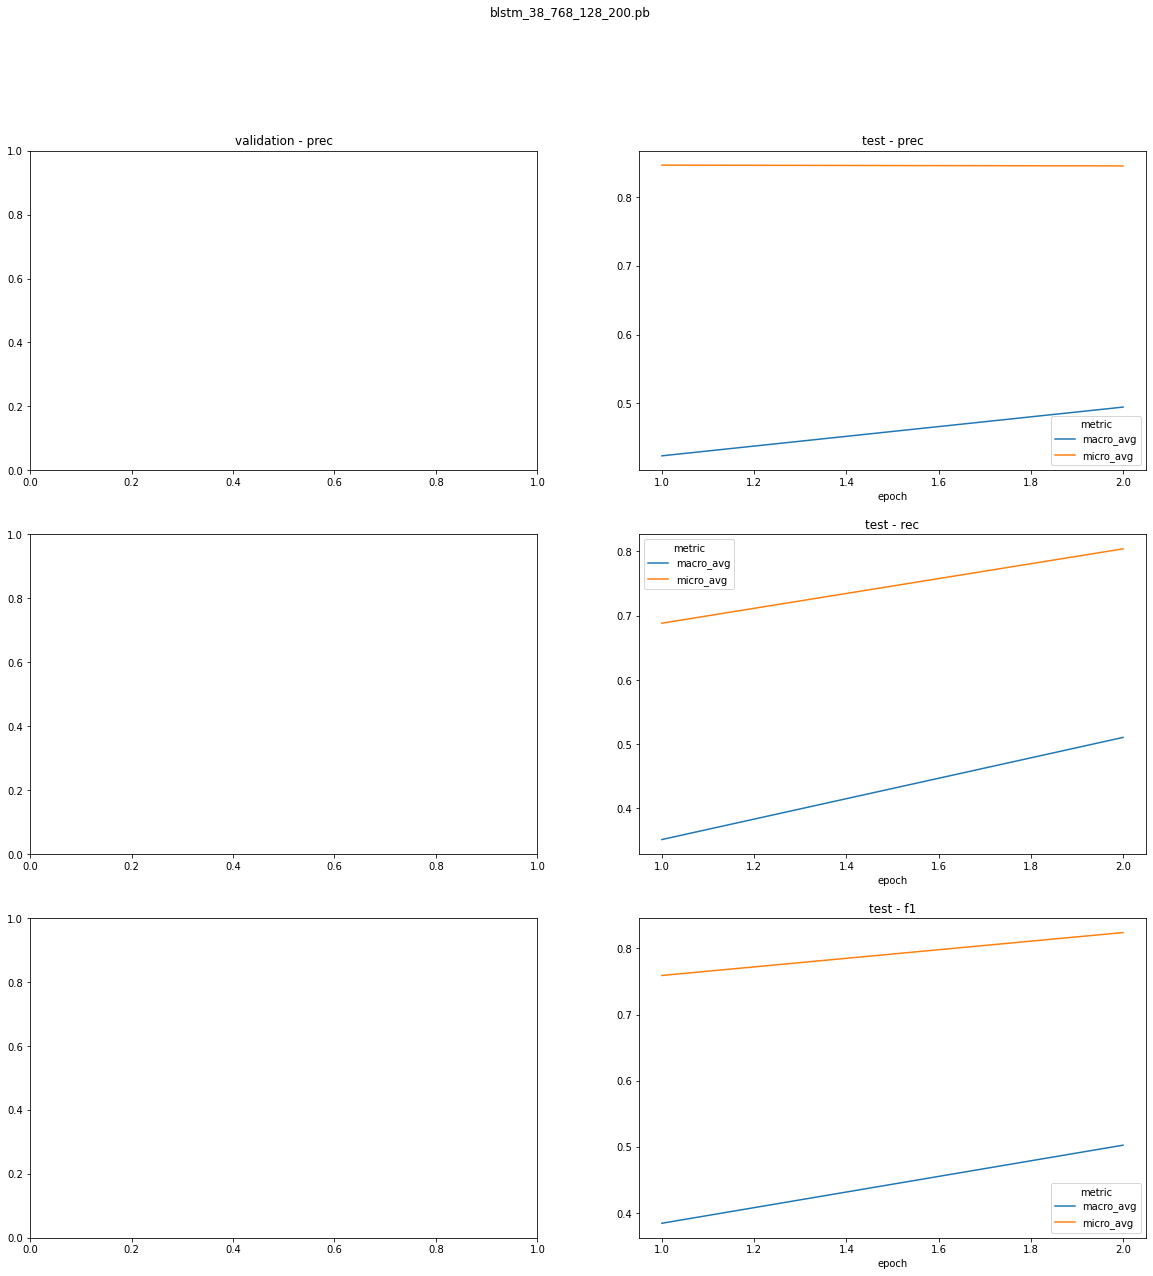

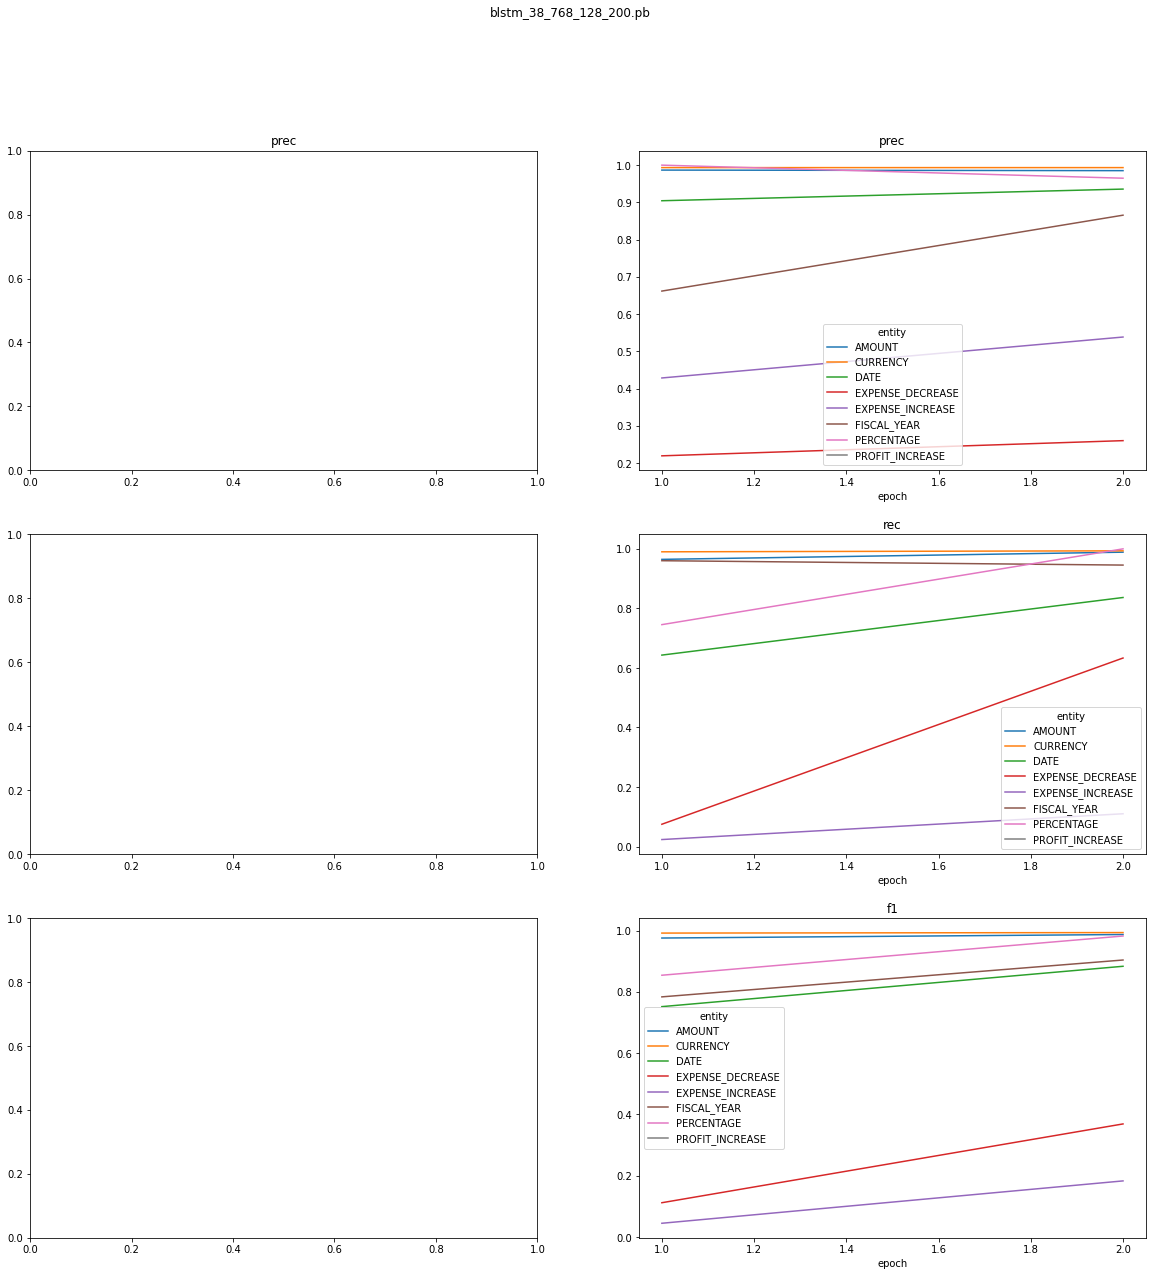

In [0]:
ner_log_parser.get_charts('/dbfs/ner_logs_best/'+log_files[0])

**Plotting Loss**

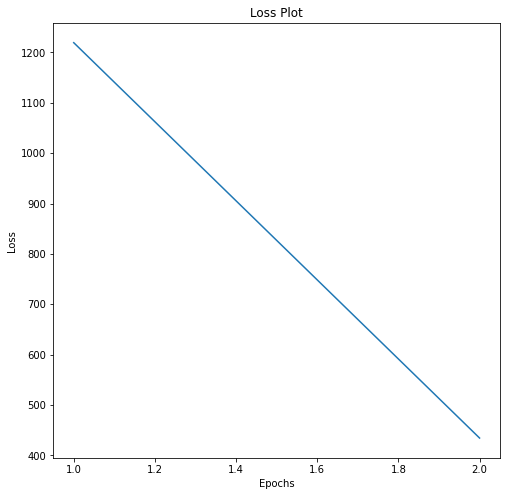

In [0]:
ner_log_parser.loss_plot('/dbfs/ner_logs_best/'+log_files[0])

### Saving the trained model

In [0]:
ner_model.stages

Out[36]: [WORD_EMBEDDINGS_MODEL_48cffc8b9a76, NerDLModel_14dd804a23d6]

In [0]:
%sh cd /databricks/driver/ && ls -la

total 9380
drwxr-xr-x 1 root root    4096 Mar 10 11:46 .
drwxr-xr-x 1 root root    4096 Mar 10 11:34 ..
drwxr-xr-x 2 root root    4096 Mar 10 11:46 __pycache__
drwxr-xr-x 2 root root    4096 Mar 10 10:59 azure
drwxr-xr-x 2 root root    4096 Mar 10 10:59 conf
-rw-r--r-- 1 root root    7431 Mar 10 11:37 conll_eval.py
-rw-r--r-- 1 root root    7431 Mar 10 11:42 conll_eval.py.1
-rw-r--r-- 1 root root  827443 Mar 10 11:34 eng.testa
-rw-r--r-- 1 root root  827443 Mar 10 11:39 eng.testa.1
-rw-r--r-- 1 root root 3283420 Mar 10 11:34 eng.train
-rw-r--r-- 1 root root 3283420 Mar 10 11:39 eng.train.1
drwxr-xr-x 3 root root    4096 Mar 10 11:30 eventlogs
drwxr-xr-x 2 root root    4096 Mar 10 11:45 ganglia
-r-xr-xr-x 1 root root    3037 Mar 10 10:59 hadoop_accessed_config.lst
drwxr-xr-x 2 root root    4096 Mar 10 11:30 logs
-rw-r--r-- 1 root root    3826 Mar 10 11:46 ner_log_parser.py
-r-xr-xr-x 1 root root 1307287 Mar 10 10:59 preload_class.lst


In [0]:
ner_model.stages[-1].write().overwrite().save('dbfs:/databricks/driver/models/NerDLModel_5e32b')

## Prediction Pipeline

In [0]:
document = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentence = SentenceDetector()\
    .setInputCols(['document'])\
    .setOutputCol('sentence')

token = Tokenizer()\
    .setInputCols(['sentence'])\
    .setOutputCol('token')

glove_embeddings = WordEmbeddingsModel.pretrained('glove_100d')\
    .setInputCols(["document", "token"])\
    .setOutputCol("embeddings")
    
loaded_ner_model = NerDLModel.load("dbfs:/databricks/driver/models/NerDLModel_5e32b")\
     .setInputCols(["sentence", "token", "embeddings"])\
     .setOutputCol("ner")

converter = NerConverter()\
      .setInputCols(["document", "token", "ner"])\
      .setOutputCol("ner_span")

ner_prediction_pipeline = Pipeline(
    stages = [
        document,
        sentence,
        token,
        glove_embeddings,
        loaded_ner_model,
        converter])

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]


In [0]:
empty_data = spark.createDataFrame([['']]).toDF("text")

prediction_model = ner_prediction_pipeline.fit(empty_data)


In [0]:
text = "Peter Parker is a nice guy and lives in New York."

sample_data = spark.createDataFrame([[text]]).toDF("text")

sample_data.show(truncate=False)

+-------------------------------------------------+
|text                                             |
+-------------------------------------------------+
|Peter Parker is a nice guy and lives in New York.|
+-------------------------------------------------+



In [0]:
preds = prediction_model.transform(sample_data)

preds.select(F.explode(F.arrays_zip(preds.ner_span.result,preds.ner_span.metadata)).alias("entities")) \
      .select(F.expr("entities['0']").alias("chunk"),
              F.expr("entities['1'].entity").alias("entity")).show(truncate=False)

+------------+------+
|chunk       |entity|
+------------+------+
|Peter Parker|PER   |
|New York    |LOC   |
+------------+------+



In [0]:
from sparknlp.base import LightPipeline

light_model = LightPipeline(prediction_model)

In [0]:
text = "Peter Parker is a nice guy and lives in New York."

result = light_model.annotate(text)

list(zip(result['token'], result['ner']))

Out[44]: [('Peter', 'B-PER'),
 ('Parker', 'I-PER'),
 ('is', 'O'),
 ('a', 'O'),
 ('nice', 'O'),
 ('guy', 'O'),
 ('and', 'O'),
 ('lives', 'O'),
 ('in', 'O'),
 ('New', 'B-LOC'),
 ('York', 'I-LOC'),
 ('.', 'O')]

In [0]:
import pandas as pd

result = light_model.fullAnnotate(text)

ner_df= pd.DataFrame([(int(x.metadata['sentence']), x.result, x.begin, x.end, y.result) for x,y in zip(result[0]["token"], result[0]["ner"])], 
                      columns=['sent_id','token','start','end','ner'])
ner_df

,sent_id,token,start,end,ner
0,0,Peter,0,4,B-PER
1,0,Parker,6,11,I-PER
2,0,is,13,14,O
3,0,a,16,16,O
4,0,nice,18,21,O
5,0,guy,23,25,O
6,0,and,27,29,O
7,0,lives,31,35,O
8,0,in,37,38,O
9,0,New,40,42,B-LOC


# Creating your own CoNLL dataset

for a detailed overview of how to create a CoNLL file from any annotation, see here >> https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/1.3.prepare_CoNLL_from_annotations_for_NER.ipynb

In [0]:
import json
import os
from pyspark.ml import Pipeline
from sparknlp.base import *
from sparknlp.annotator import *
import sparknlp

spark = sparknlp.start()

def get_ann_pipeline ():
    
    document_assembler = DocumentAssembler() \
        .setInputCol("text")\
        .setOutputCol('document')

    sentence = SentenceDetector()\
        .setInputCols(['document'])\
        .setOutputCol('sentence')
    
    tokenizer = Tokenizer() \
        .setInputCols(["sentence"]) \
        .setOutputCol("token")

    pos = PerceptronModel.pretrained() \
              .setInputCols(["sentence", "token"]) \
              .setOutputCol("pos")
    
    embeddings = WordEmbeddingsModel.pretrained()\
          .setInputCols(["sentence", "token"])\
          .setOutputCol("embeddings")

    ner_model = NerDLModel.pretrained() \
          .setInputCols(["sentence", "token", "embeddings"]) \
          .setOutputCol("ner")

    ner_converter = NerConverter()\
      .setInputCols(["sentence", "token", "ner"])\
      .setOutputCol("ner_chunk")

    ner_pipeline = Pipeline(
        stages = [
            document_assembler,
            sentence,
            tokenizer,
            pos,
            embeddings,
            ner_model,
            ner_converter
        ]
    )

    empty_data = spark.createDataFrame([[""]]).toDF("text")

    ner_pipelineFit = ner_pipeline.fit(empty_data)

    ner_lp_pipeline = LightPipeline(ner_pipelineFit)

    print ("Spark NLP NER lightpipeline is created")

    return ner_lp_pipeline


conll_pipeline = get_ann_pipeline()



pos_anc download started this may take some time.
Approximate size to download 3.9 MB
[OK!]
glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]
ner_dl download started this may take some time.
Approximate size to download 13.6 MB
[OK!]
Spark NLP NER lightpipeline is created


In [0]:
sentences = ["Peter Parker is a nice guy and lives in New York.",
"He is also helping people around the world."]

conll_lines=''

for sentence in sentences:

  parsed = conll_pipeline.annotate (sentence)

  for token, pos, ner in zip(parsed['token'],parsed['pos'],parsed['ner']):

      conll_lines += "{} {} {} {}\n".format(token, pos, pos, ner)

  conll_lines += '\n'


print(conll_lines)

Peter NNP NNP B-PER
Parker NNP NNP I-PER
is VBZ VBZ O
a DT DT O
nice JJ JJ O
guy NN NN O
and CC CC O
lives NNS NNS O
in IN IN O
New NNP NNP B-LOC
York NNP NNP I-LOC
. . . O

He PRP PRP O
is VBZ VBZ O
also RB RB O
helping VBG VBG O
people NNS NNS O
around IN IN O
the DT DT O
world NN NN O
. . . O




End of Notebook #